In [1]:
import sympy as sp
from sympt import display_dict, group_by_operators, Operator
import numpy as np
from tqdm import tqdm
# scipy integration
from scipy.integrate import quad
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize

# Transparent background for figures but keep the legend background white but its text color black
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.edgecolor'] = 'none'
plt.rcParams['legend.framealpha'] = 0.8
plt.rcParams['legend.shadow'] = False
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'
# White spins, axis and ticks 
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'


## Multivariable Taylor Series

In [2]:
from itertools import product

def multivariable_taylor_series(expr, x, x0, n, return_dict=True):
    res = {}
    variables = range(len(x))
    subs_dict = dict(zip(x, x0))
    for k in range(n+1):
        derivatives = []
        terms = []

        for i_k in product(variables, repeat=k):
            if not i_k:
                derivatives.append(expr.subs(subs_dict))
                terms.append(1)
                continue
            x_k = [x[i] for i in i_k]
            x0_k = [x0[i] for i in i_k]
            derivatives.append(expr.diff(*x_k).subs(subs_dict))
            terms.append(sp.Mul(*[(x_k[i] - x0_k[i]) for i in range(k)]))
        
        res[k] = (np.array(derivatives, dtype=object), np.array(terms, dtype=object))
    if not return_dict:
        res = sp.Add(*[sp.Rational(1, sp.factorial(k)) * sp.Add(*(derivatives * terms)) for k, (derivatives, terms) in res.items()])
        
    return res
            

In [3]:
def Ik(k):
    if k % 2 != 0:
        return 0
    return sp.pi * sp.factorial2(k - 1) / sp.factorial2(k)


def I(a, b, N):
    res = 0
    for k in range(1, N+1):
        if (k + 1) % 2 != 0:
            continue
        res += sp.binomial(-sp.Rational(1,2), k) * (-1) ** k * (b**(2*k))/(a**(2*k + 1)) * Ik(k + 1)
    return res

def T(order, lenght, include_zero=True):
    if include_zero:
        orders = product(range(order+1), repeat=lenght)
    else:
        orders = product(range(1, order+1), repeat=lenght)
    result_orders = []
    for t in orders:
        if np.sum(t) != order:
            continue
        result_orders.append(t)
    
    return result_orders


def J(a, R, r, N):
    res = 0
    for k in range(N+1):
        res_k = 0
        coeff = (2 * r * R)**k * (R * Ik(k) - r * Ik(k + 1))

        for (n, m) in T(k, 2):
            res_k += sp.binomial(-sp.Rational(1,2), n) * (-1)**n / ( (r**2 + R**2) ** (m + 1) * (a**(2*n + 1)))

        res += coeff * res_k

    return res
            
        

class CylindricalMagnet:
    def __init__(self, R, L, position : sp.Matrix):
        self.position = position
        self.geometry = {'R': R, 'L': L}
        self.B0 = sp.symbols('B0', real = True, positive = True)


    def B(self, values, r_charge):
        self.geometry['R'] = values['R']
        self.geometry['L'] = values['L']
        self.B0 = values['B0']

        self.position = values['position']


        rho = r_charge - self.position    # vector from magnet to charge

        x, y, z = rho
        r = np.sqrt(x**2 + y**2)

        phi = np.arctan2(y, x)

        xi_p = z + 1/2 * self.geometry['L']
        xi_m = z - 1/2 * self.geometry['L']

        fr_p = lambda theta: np.cos(theta) / np.sqrt(xi_p**2 + self.geometry['R']**2 + r**2 - 2 * self.geometry['R'] * r * np.cos(theta))
        fr_m = lambda theta: np.cos(theta) / np.sqrt(xi_m**2 + self.geometry['R']**2 + r**2 - 2 * self.geometry['R'] * r * np.cos(theta))

        fz_p = lambda theta: xi_p * (self.geometry['R'] - r * np.cos(theta)) / ((r**2 + self.geometry['R']**2 - 2*self.geometry['R']*r*np.cos(theta)) * np.sqrt(xi_p**2 + self.geometry['R']**2 + r**2 - 2 * self.geometry['R'] * r * np.cos(theta)))
        fz_m = lambda theta: xi_m * (self.geometry['R'] - r * np.cos(theta)) / ((r**2 + self.geometry['R']**2 - 2*self.geometry['R']*r*np.cos(theta)) * np.sqrt(xi_m**2 + self.geometry['R']**2 + r**2 - 2 * self.geometry['R'] * r * np.cos(theta)))


        Br = - 2 * self.B0 * self.geometry['R'] * (quad(fr_p, 0, sp.pi)[0] - quad(fr_m, 0, sp.pi)[0])
        Bz = 2 * self.B0 * self.geometry['R'] * (quad(fz_p, 0, sp.pi)[0] - quad(fz_m, 0, sp.pi)[0])

        self.r = r

        return Br * x/r , Br * y/r, Bz
    
    def B_integral_expansion(self, r_charge: sp.Matrix, order=3):

        rho = r_charge - self.position    # vector from magnet to charge

        x, y, z = rho
        r = sp.sqrt(x**2 + y**2)
        r_symbol = sp.symbols('r', real = True, positive = True)

        xi_p = z + sp.Rational(1, 2) * self.geometry['L']
        xi_m = z - sp.Rational(1, 2) * self.geometry['L']

        a_plus = sp.sqrt(xi_p**2 + self.geometry['R']**2 + r**2)
        a_minus = sp.sqrt(xi_m**2 + self.geometry['R']**2 + r**2)
        b = sp.sqrt(2 * r_symbol * self.geometry['R'])

        I_plus = sp.Add(*[term.collect(r_symbol) / r_symbol for term in I(a_plus, b, order).as_ordered_terms()]).subs(r_symbol, r)
        I_minus = sp.Add(*[term.collect(r_symbol) / r_symbol for term in I(a_minus, b, order).as_ordered_terms()]).subs(r_symbol, r)

        J_plus = xi_p * J(a_plus, self.geometry['R'], r_symbol, order).subs(r_symbol, r)
        J_minus = xi_m * J(a_minus, self.geometry['R'], r_symbol, order).subs(r_symbol, r)

        Bx = - 2 * self.B0 * self.geometry['R'] * (I_plus - I_minus) * x
        By = - 2 * self.B0 * self.geometry['R'] * (I_plus - I_minus) * y
        Bz = 2 * self.B0 * self.geometry['R'] * (J_plus - J_minus) 

        return Bx, By, Bz

In [4]:
R, L = sp.symbols('R L', real = True, positive = True)

Dx, Dy, Dz = sp.symbols('Delta_x Delta_y Delta_z', real = True)
x, y = sp.symbols('x y', real = True)

CYM = CylindricalMagnet(R, L, sp.Matrix([Dx, Dy, Dz]))

integral_order = 7
taylor_expansion_order = [3, 3, 2]
Bx, By, Bz = CYM.B_integral_expansion(sp.Matrix([x, y, 0]), order=integral_order)

Delta_r, Delta_rho = sp.symbols('Delta_r Delta_rho', real = True, positive = True)

def apply_simplifications(expr):
    expr = expr.subs(Dx**2 + Dy**2 + Dz**2, Delta_rho**2)
    #expr = expr.subs(Dx**2 + Dy**2, Delta_r**2)
    expr = expr.subs(Delta_r**2 , Delta_rho**2 - Dz**2)
    expr = expr.subs(Delta_rho**2 - Dz**2, Delta_r**2)

    return expr.collect(R*sp.pi).collect([Dx, Dy]).collect(2*CYM.B0*R)

print('Computing taylor series')
Bx_taylor_series = multivariable_taylor_series(Bx, [x, y], [0, 0], taylor_expansion_order[0], return_dict=False)
print('Bx done')
By_taylor_series = multivariable_taylor_series(By, [x, y], [0, 0], taylor_expansion_order[1], return_dict=False)
print('By done')
Bz_taylor_series = multivariable_taylor_series(Bz, [x, y], [0, 0], taylor_expansion_order[2], return_dict=False)
print('Bz done')


print('\nLambdifying')
bx_taylor_series = sp.lambdify((x, y, R, L, CYM.B0, Dx, Dy, Dz), Bx_taylor_series, 'numpy')
print('Bx done')
by_taylor_series = sp.lambdify((x, y, R, L, CYM.B0, Dx, Dy, Dz), By_taylor_series, 'numpy')
print('By done')
bz_taylor_series = sp.lambdify((x, y, R, L, CYM.B0, Dx, Dy, Dz), Bz_taylor_series, 'numpy')
print('Bz done')


R_val = 0.5
Dx_val = 2
Dy_val = 0
L_val = 1
Dz_val = 150 / 60
M = 100_000
mu_0 = 4 * np.pi * 10**-7
B0 = 1#mu_0 * M / (4 * np.pi )


r_val = np.sqrt(Dx_val**2 + Dy_val**2)

xs = np.linspace(-4, 4, 50)
ys = np.linspace(-4, 4, 50)

Bx_exact = np.zeros((len(xs), len(ys)))
By_exact = np.zeros((len(xs), len(ys)))
Bz_exact = np.zeros((len(xs), len(ys)))

iterable = []
for i, y in enumerate(ys):
    for j, x in enumerate(xs):
        iterable.append((i, j, y, x))

values = {'R': R_val, 'L': L_val, 'B0': B0, 'position': np.array([Dx_val, Dy_val, Dz_val])}
positions = np.zeros(Bx_exact.shape + (2,))

for i, j, y, x in tqdm(iterable):
    positions[i, j] = np.array([y, x])
    Bx_exact[i, j], By_exact[i, j], Bz_exact[i, j] = CYM.B(values, np.array([x, y, 0]))

Computing taylor series
Bx done
By done
Bz done

Lambdifying
Bx done
By done
Bz done


100%|██████████| 2500/2500 [00:01<00:00, 1447.62it/s]


  0%|          | 0/2500 [00:00<?, ?it/s]

100%|██████████| 2500/2500 [00:01<00:00, 1936.71it/s]


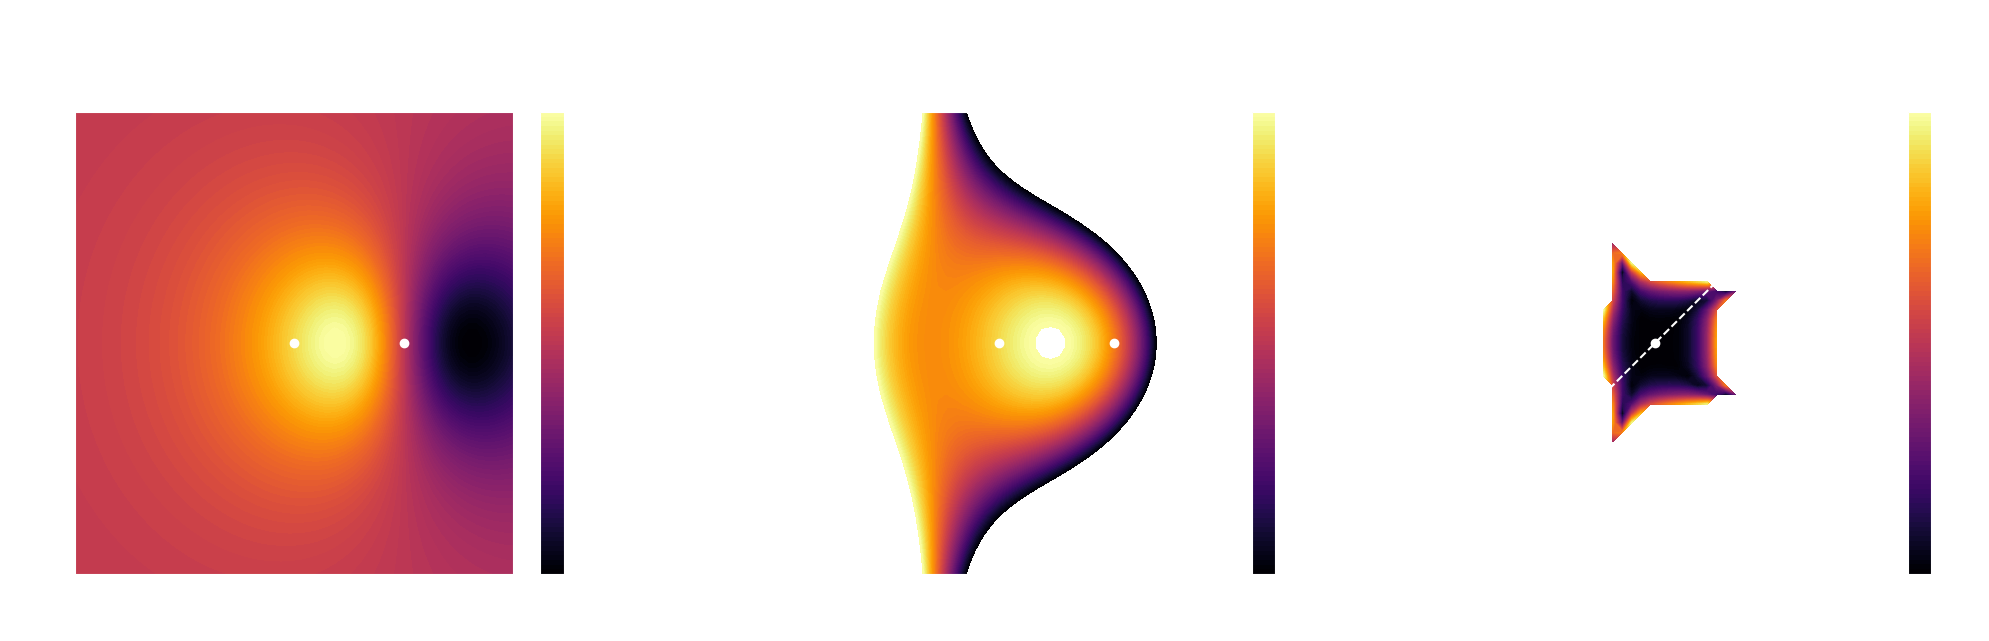

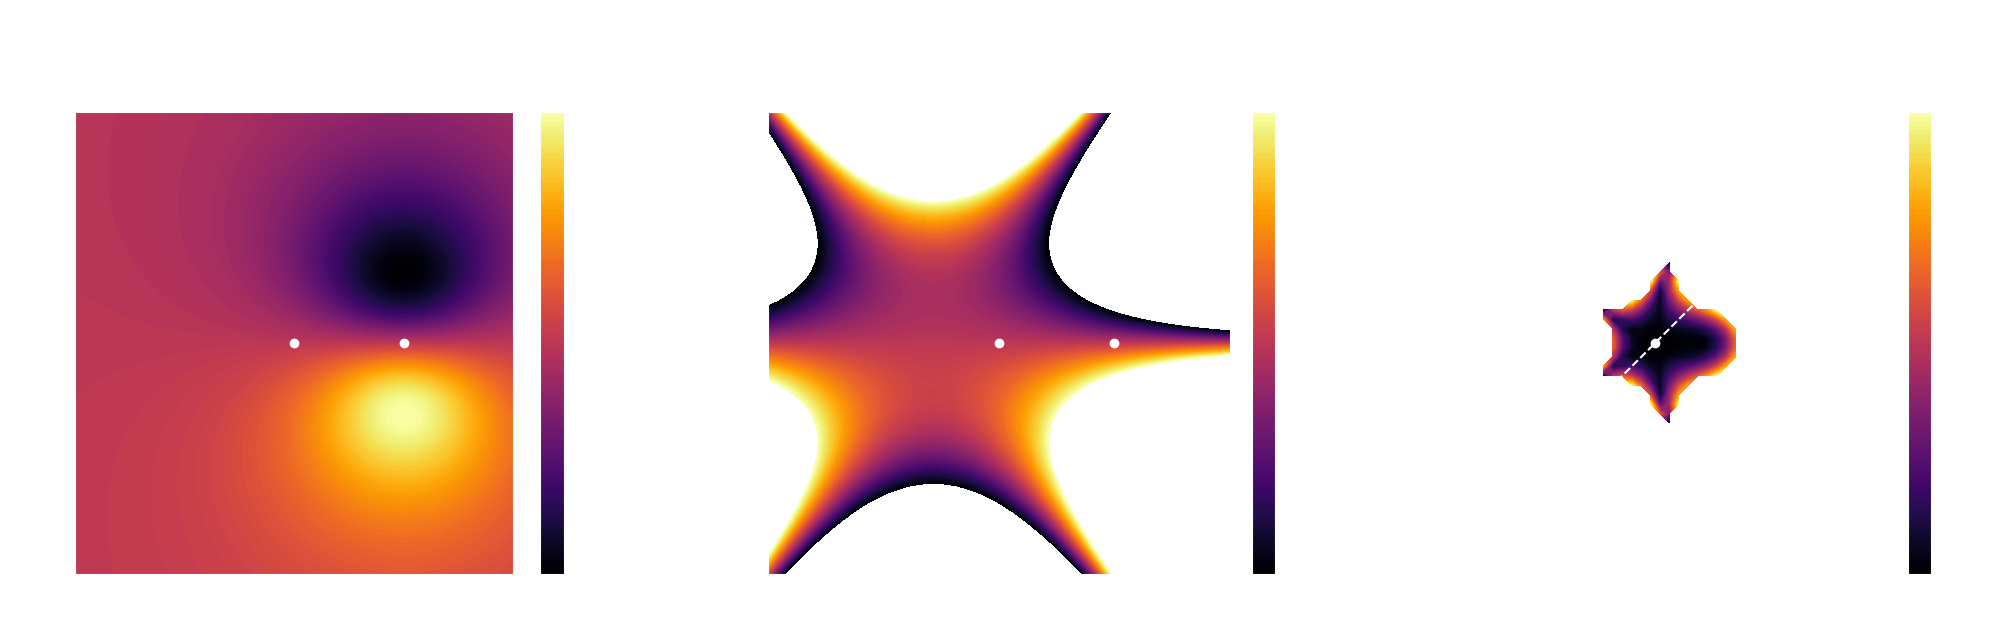

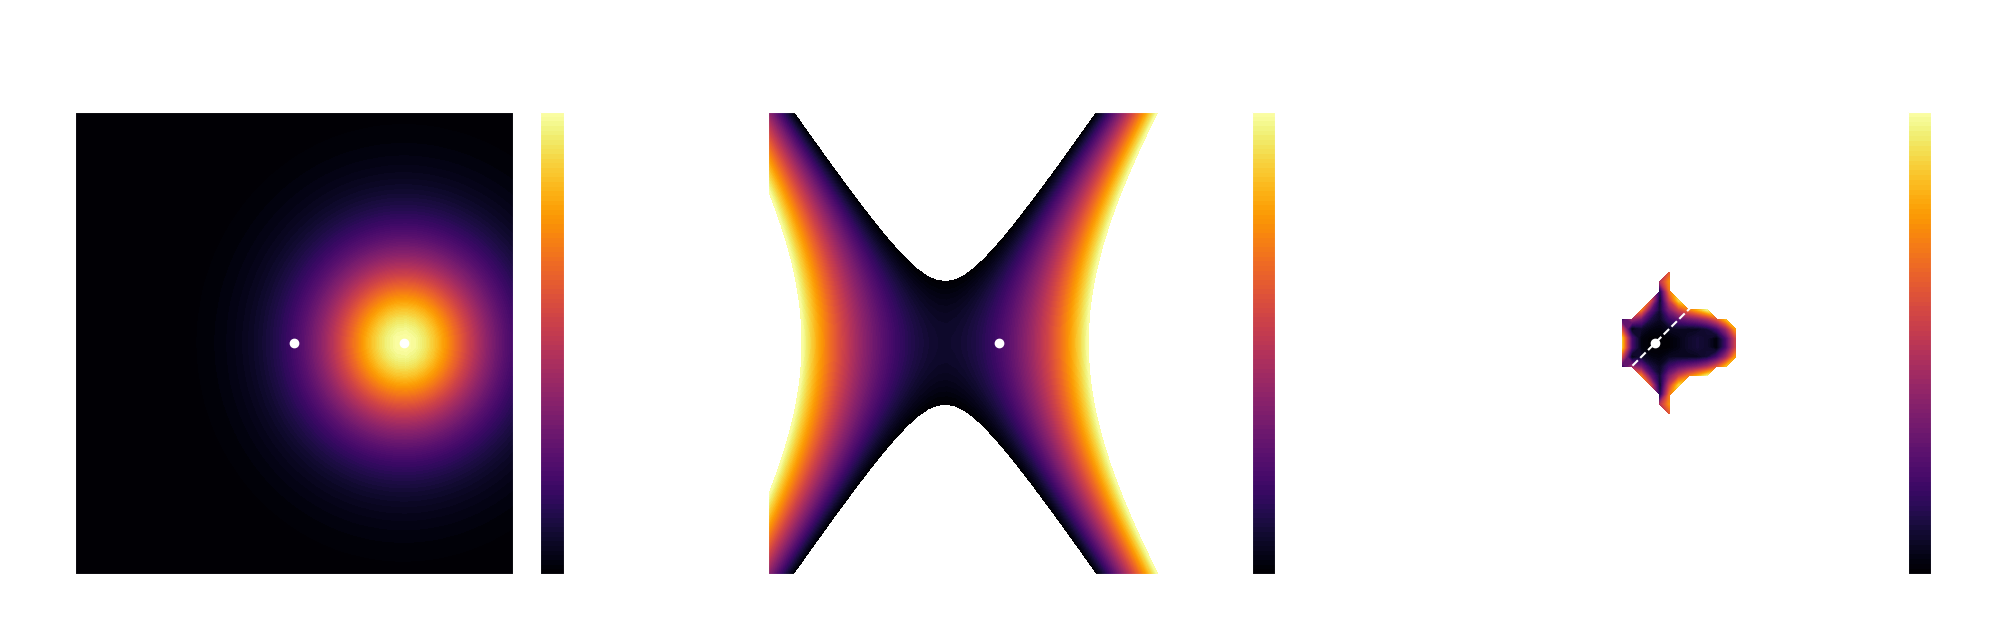

In [5]:
Bx_analytical = np.zeros_like(Bx_exact)
By_analytical = np.zeros_like(Bx_exact)
Bz_analytical = np.zeros_like(Bx_exact)

for i, j, y, x in tqdm(iterable):
    #Bx_poly[i, j] = func([y, x], *popt)
    Bx_analytical[i, j] = bx_taylor_series(x, y, R_val, L_val, B0, Dx_val, Dy_val, Dz_val)
    By_analytical[i, j] = by_taylor_series(x, y, R_val, L_val, B0, Dx_val, Dy_val, Dz_val)
    Bz_analytical[i, j] = bz_taylor_series(x, y, R_val, L_val, B0, Dx_val, Dy_val, Dz_val)

B_exact = [Bx_exact, By_exact, Bz_exact]
B_analytical = [Bx_analytical, By_analytical, Bz_analytical]

e_xs = 'xyz'

for e_x, (b_exact, b_analytical) in enumerate(zip(B_exact, B_analytical)):

    # ----------------- Numerical -----------------

    fig, axs = plt.subplots(1, 3, figsize=(24, 6))

    b_min = np.min(b_exact)
    b_max = np.max(b_exact)
    levels = np.linspace(b_min, b_max, 100)

    ax = axs[0]
    im = ax.contourf(xs, ys, b_exact, levels=levels, cmap='inferno')
    fig.colorbar(im)
    ax.set_title(f'Numerical solution $B_{e_xs[e_x]}(x, y)$', fontsize=16, color='white')
    ax.set_xlabel('$x$ [nm]', fontsize=16, color='white')
    ax.set_ylabel('$y$ [nm]', fontsize=16, color='white')
    # Point where the magnet is located
    ax.plot(Dx_val, Dy_val, 'o', color='white')
    ax.text(Dx_val, Dy_val + 5, 'Magnet', color='white', fontsize=12, ha='center', va='top')
    # Point where the charge is located
    ax.plot(0, 0, 'o', color='white')
    ax.text(0, 0 + 5, 'QD', color='white', fontsize=12, ha='center', va='top')
    # circle radius 30
    circle = plt.Circle((0, 0), 30, color='white', fill=False)
    ax.add_artist(circle)

    # ----------------- Analytical -----------------

    ax = axs[1]
    im = ax.contourf(xs, ys, b_analytical, levels=levels, cmap='inferno')
    fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.05, pad=0.04)

    ax = axs[2]
    error_analytical = np.abs((b_analytical - b_exact)) / np.abs(b_exact)
    error_analytical[error_analytical > 0.1] = np.nan
    im = ax.contourf(xs, ys, error_analytical, levels=100, cmap='inferno')
    fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.05, pad=0.04)

    # Figure title
    fig.suptitle(f'Analytical vs Numerical solution $B_{e_xs[e_x]}(x, y)$\n Integral order: {integral_order}, Taylor expansion order: {taylor_expansion_order[e_x]}', fontsize=20, color='white', y=1.05)

    axs[1].set_title(f'Analytical solution $B_{e_xs[e_x]}(x, y)$', fontsize=16, color='white')
    axs[1].set_xlabel('$x$ [nm]', fontsize=16, color='white')
    axs[1].set_ylabel('$y$ [nm]', fontsize=16, color='white')
    # Point where the magnet is located
    axs[1].plot(Dx_val, Dy_val, 'o', color='white')
    axs[1].text(Dx_val, Dy_val + 5, 'Magnet', color='white', fontsize=12, ha='center', va='top')
    # Point where the charge is located
    axs[1].plot(0, 0, 'o', color='white')
    axs[1].text(0, 0 + 5, 'QD', color='white', fontsize=12, ha='center', va='top')
    # circle radius 30
    circle = plt.Circle((0, 0), 30, color='white', fill=False)
    axs[1].add_artist(circle)

    axs[2].set_title(f'Relative error $B_{e_xs[e_x]}(x, y)$', fontsize=16, color='white')
    axs[2].set_xlabel('$x$ [nm]', fontsize=16, color='white')
    axs[2].set_ylabel('$y$ [nm]', fontsize=16, color='white')
    # Point where the magnet is located
    axs[2].plot(Dx_val, Dy_val, 'o', color='white')
    axs[2].text(Dx_val, Dy_val + 5, 'Magnet', color='white', fontsize=12, ha='center', va='top')
    # Point where the charge is located
    axs[2].plot(0, 0, 'o', color='white')
    axs[2].text(0, 0 + 5, 'QD', color='white', fontsize=12, ha='center', va='top')
    # circle radius 30
    circle = plt.Circle((0, 0), 30, color='white', fill=False)
    axs[2].add_artist(circle)
    #Equal axes
    axs[1].set_aspect('equal')
    axs[2].set_aspect('equal')
    # line y=x
    rs = np.linspace(-4, 4, 100)
    xs_ = rs * np.cos(np.pi/4)
    ys_ = rs * np.sin(np.pi/4)
    axs[2].plot(xs_, ys_, 'w--')

    # close figure
    plt.show()
    plt.close(fig)


In [6]:
from multiprocessing import Pool
num_cpu = 10

R, L = sp.symbols('R L', real = True, positive = True)

Dx, Dy, Dz = sp.symbols('Delta_x Delta_y Delta_z', real = True)
x, y = sp.symbols('x y', real = True)


values = {'R': R_val, 'L': L_val, 'B0': B0, 'position': np.array([Dx_val, Dy_val, Dz_val])}

rs = np.linspace(-30, 29, 100)
xs = rs * np.cos(np.pi/4)
ys = rs * np.sin(np.pi/4)

Bx_exact = np.zeros_like(rs)
By_exact = np.zeros_like(rs)
Bz_exact = np.zeros_like(rs)
CYM = CylindricalMagnet(R, L, sp.Matrix([Dx, Dy, Dz]))

for i, (x_val, y_val) in enumerate(zip(xs, ys)):
    Bx_exact[i], By_exact[i], Bz_exact[i] = CYM.B(values, np.array([x_val, y_val, 0]))

max_integral_order = 6
integral_orders = np.arange(1, max_integral_order + 1, 2)
taylor_expansion_orders = np.arange(1, 4)

CYM = CylindricalMagnet(R, L, sp.Matrix([Dx, Dy, Dz]))
total_errors_x = np.zeros((len(taylor_expansion_orders), len(integral_orders)))
total_errors_y = np.zeros((len(taylor_expansion_orders), len(integral_orders)))
total_errors_z = np.zeros((len(taylor_expansion_orders), len(integral_orders)))
Bx_analyticals = np.zeros((len(taylor_expansion_orders), len(integral_orders), len(rs)))
By_analyticals = np.zeros((len(taylor_expansion_orders), len(integral_orders), len(rs)))
Bz_analyticals = np.zeros((len(taylor_expansion_orders), len(integral_orders), len(rs)))

def compute_error_integral_order(integral_order):
    Bx, By, Bz = CYM.B_integral_expansion(sp.Matrix([x, y, 0]), order=integral_order)

    Bx_taylor_series = multivariable_taylor_series(Bx, [x, y], [0, 0], taylor_expansion_order, return_dict=False)
    bx_taylor_series = sp.lambdify((x, y, R, L, CYM.B0, Dx, Dy, Dz), apply_simplifications(Bx_taylor_series), 'numpy')

    By_taylor_series = multivariable_taylor_series(By, [x, y], [0, 0], taylor_expansion_order, return_dict=False)
    by_taylor_series = sp.lambdify((x, y, R, L, CYM.B0, Dx, Dy, Dz), apply_simplifications(By_taylor_series), 'numpy')

    Bz_taylor_series = multivariable_taylor_series(Bz, [x, y], [0, 0], taylor_expansion_order, return_dict=False)
    bz_taylor_series = sp.lambdify((x, y, R, L, CYM.B0, Dx, Dy, Dz), apply_simplifications(Bz_taylor_series), 'numpy')

    Bx_analytical = bx_taylor_series(xs, ys, R_val, L_val, B0, Dx_val, Dy_val, Dz_val)
    By_analytical = by_taylor_series(xs, ys, R_val, L_val, B0, Dx_val, Dy_val, Dz_val)
    Bz_analytical = bz_taylor_series(xs, ys, R_val, L_val, B0, Dx_val, Dy_val, Dz_val)

    total_error_x = 1 - np.sqrt(np.sum((Bx_exact - Bx_analytical)**2) / (np.dot(Bx_exact, Bx_exact) + np.dot(Bx_analytical, Bx_analytical)))
    total_error_y = 1 - np.sqrt(np.sum((By_exact - By_analytical)**2) / (np.dot(By_exact, By_exact) + np.dot(By_analytical, By_analytical)))
    total_error_z = 1 - np.sqrt(np.sum((Bz_exact - Bz_analytical)**2) / (np.dot(Bz_exact, Bz_exact) + np.dot(Bz_analytical, Bz_analytical)))

    return (Bx_analytical, total_error_x), (By_analytical, total_error_y), (Bz_analytical, total_error_z)


for i, taylor_expansion_order in enumerate(tqdm(taylor_expansion_orders)):
    
    with Pool(num_cpu) as p:
        results = p.map(compute_error_integral_order, integral_orders)
        
    for j, ((Bx_analytical, total_error_x), (By_analytical, total_error_y), (Bz_analytical, total_error_z)) in enumerate(results):
        total_errors_x[i, j] = total_error_x
        Bx_analyticals[i, j] = Bx_analytical

        total_errors_y[i, j] = total_error_y
        By_analyticals[i, j] = By_analytical

        total_errors_z[i, j] = total_error_z
        Bz_analyticals[i, j] = Bz_analytical
        

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:03<00:06,  3.26s/it]Process ForkPoolWorker-13:
Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Process ForkPoolWorker-17:
Process ForkPoolWorker-18:
Process ForkPoolWorker-19:
Process ForkPoolWorker-20:
Process ForkPoolWorker-14:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/leander/miniconda3/envs/sympt/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/leander/miniconda3/envs/sympt/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/leander/miniconda3/envs/sympt/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/leander/miniconda3/envs/sympt/lib/python3.11/multiprocessing/process.py", l

KeyboardInterrupt: 

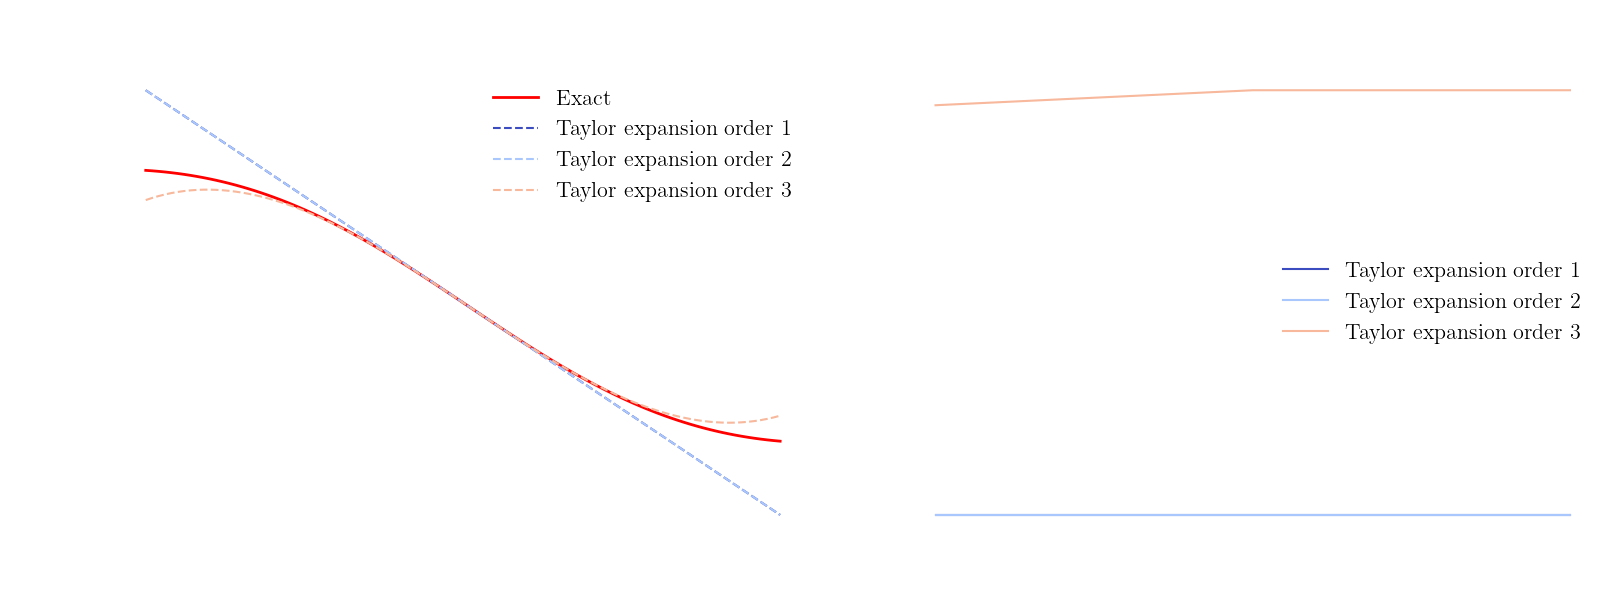

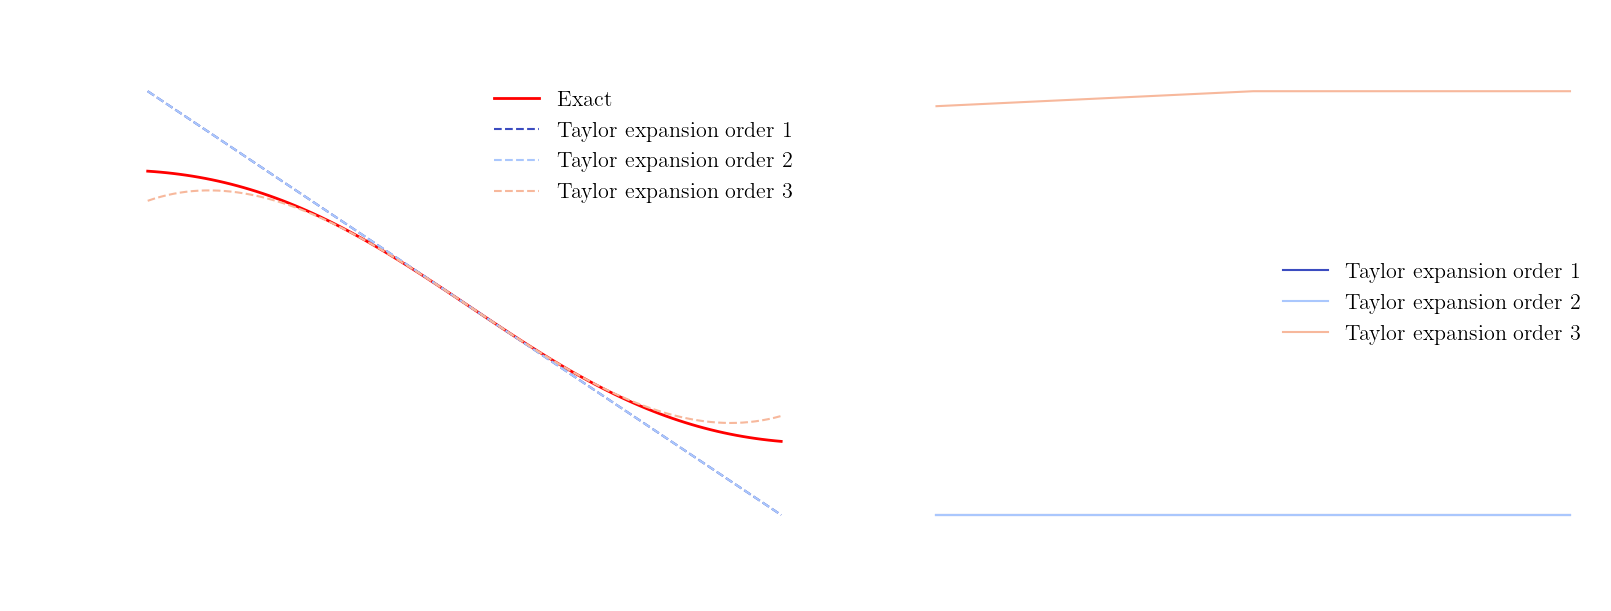

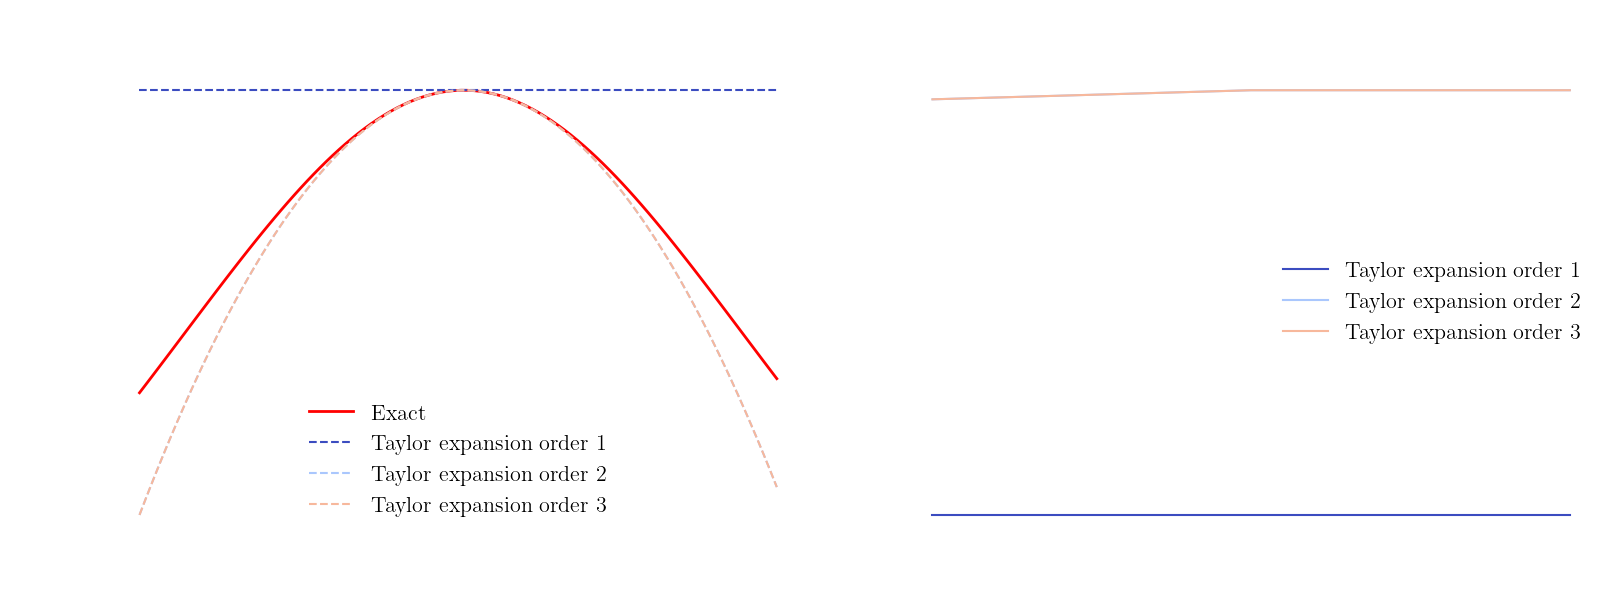

In [ ]:
cmap = plt.get_cmap('coolwarm')

integral_order = 5
j = np.where(integral_orders == integral_order)[0][0]

axis = 'xyz'

for e_x, (b_exact, b_analytical, total_errors) in enumerate(zip([Bx_exact, By_exact, Bz_exact], [Bx_analyticals, By_analyticals, Bz_analyticals], [total_errors_x, total_errors_y, total_errors_z])):

    fig, axs = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
    ax = axs[0]

    fig.suptitle(f'Analytical vs Numerical solution $B_{axis[e_x]}(r)$', fontsize=20, color='white')

    ax.set_title(f'Integral order: {integral_order}', fontsize=16, color='white')
    ax.plot(rs, b_exact, label='Exact', color='red', lw=2)
    # colors ignoring the balck one
    colors = [cmap(i/(len(taylor_expansion_orders))) for i in range(len(taylor_expansion_orders))]
    for i, taylor_expansion_order in enumerate(taylor_expansion_orders):    
        ax.plot(rs, b_analytical[i, j], label='Taylor expansion order ' + str(taylor_expansion_order), color=colors[i], ls='--')
    ax.legend()
    ax.set_xlabel('$r = \sqrt{x^2 + y^2} \le 30$ [nm]')
    ax.set_ylabel(f'$B_{axis[e_x]}$')

    ax = axs[1]
    colors = [cmap(i/len(taylor_expansion_orders)) for i in range(len(taylor_expansion_orders))]
    for i, taylor_expansion_order in enumerate(taylor_expansion_orders):
        ax.plot(integral_orders, total_errors[i], label=f'Taylor expansion order {taylor_expansion_order}', color=colors[i])

    ax.set_xlabel('Integral order')
    ax.set_ylabel('Relative error')
    ax.legend()

    plt.show()
    plt.close(fig)
